In [93]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import lightgbm as lgb
import optuna
import os
import datetime
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス



# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


df = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [94]:
# 欠損状況・ドラフト率差・欠損率を一覧表示
for col in df.columns:
    if df[col].isnull().any():
        missing_rate = df[col].isnull().mean()
        drafted_with_na = df[df[col].isnull()]["Drafted"].mean()
        drafted_without_na = df[df[col].notnull()]["Drafted"].mean()
        diff = abs(drafted_with_na - drafted_without_na)
        print(f"{col} | 欠損率: {missing_rate:.3%} | 欠損あり: {drafted_with_na:.3f}, 欠損なし: {drafted_without_na:.3f}, 差: {diff:.3f}")


Age | 欠損率: 15.642% | 欠損あり: 0.018, 欠損なし: 0.765, 差: 0.747
Sprint_40yd | 欠損率: 5.214% | 欠損あり: 0.586, 欠損なし: 0.652, 差: 0.066
Vertical_Jump | 欠損率: 19.921% | 欠損あり: 0.585, 欠損なし: 0.664, 差: 0.079
Bench_Press_Reps | 欠損率: 25.926% | 欠損あり: 0.602, 欠損なし: 0.665, 差: 0.063
Broad_Jump | 欠損率: 20.892% | 欠損あり: 0.594, 欠損なし: 0.663, 差: 0.069
Agility_3cone | 欠損率: 34.880% | 欠損あり: 0.605, 欠損なし: 0.671, 差: 0.066
Shuttle | 欠損率: 32.794% | 欠損あり: 0.601, 欠損なし: 0.671, 差: 0.071


# 📌 特徴量別の処理一覧

## ① Id
削除

In [95]:
# Id 削除
df = df.drop(columns=["Id"])
test = test.drop(columns=["Id"])

## ② Age
欠損を -1 で補完（Age_filled）

欠損フラグ（Age_missing）

元の Age カラムは 削除

In [96]:
# Age 欠損補完・欠損フラグ・元カラム削除
df["Age_filled"] = df["Age"].fillna(-1)
df["Age_missing"] = df["Age"].isna().astype(int)
df = df.drop(columns=["Age"])

test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])


In [97]:
# 欠損カラム抽出
na_cols = df.columns[df.isnull().any()]

# 中央値で補完（df / test 両方）
for col in na_cols:
    median = df[col].median()
    df[col] = df[col].fillna(median)
    test[col] = test[col].fillna(median)

In [98]:
# 欠損が残っているカラムと件数を確認
print(df.isnull().sum())

# 欠損が残っているカラムのみ抽出（確認用）
print(df.columns[df.isnull().any()])


Year                0
School              0
Height              0
Weight              0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
Player_Type         0
Position_Type       0
Position            0
Drafted             0
Age_filled          0
Age_missing         0
dtype: int64
Index([], dtype='object')


## ③ Year
特別な処理なし（そのまま使用）

In [99]:
# Year はそのまま使用（処理不要）
# df["Year"], test["Year"] をそのまま残す

## ④ Height
そのまま使用

BMI 作成に使用


In [100]:
# Height はそのまま使用
# BMI 作成に使用
df["BMI"] = df["Weight"] / (df["Height"]/100)**2
test["BMI"] = test["Weight"] / (test["Height"]/100)**2

## ⑤ Weight
そのまま使用

Weight_lbs = Weight * 2.20462 に変換

SpeedScore 作成に使用
 
BMI 作成に使用

In [101]:
# Weight はそのまま使用
# lbs 変換
df["Weight_lbs"] = df["Weight"] * 2.20462
test["Weight_lbs"] = test["Weight"] * 2.20462

# SpeedScore 作成
df["SpeedScore"] = df["Weight_lbs"] * (200 / df["Sprint_40yd"]**2)
test["SpeedScore"] = test["Weight_lbs"] * (200 / test["Sprint_40yd"]**2)


## ⑥ Sprint_40yd
そのまま使用

SpeedScore 作成に使用

RSA特徴量セットに含む



In [102]:
# Sprint_40yd はそのまま使用
# SpeedScore 作成に使用済
# RSA特徴量作成時に利用（後述）

## ⑦ Vertical_Jump
そのまま使用

BurstScore 作成に使用

RSA特徴量セットに含む

In [103]:
# Vertical_Jump はそのまま使用
# BurstScore 作成
df["BurstScore"] = df["Vertical_Jump"] + df["Broad_Jump"]
test["BurstScore"] = test["Vertical_Jump"] + test["Broad_Jump"]


## ⑧ Bench_Press_Reps
そのまま使用

RSA特徴量セットに含む

In [104]:
# Bench_Press_Reps はそのまま使用
# RSA特徴量作成時に利用（後述）


## ⑨ Broad_Jump
そのまま使用

BurstScore 作成に使用

In [105]:
# Broad_Jump はそのまま使用
# BurstScore 作成に使用済


## ⑩ Agility_3cone
そのまま使用

AgilityScore 作成に使用

RSA特徴量セットに含む

In [106]:
# Agility_3cone はそのまま使用
# AgilityScore 作成
df["AgilityScore"] = df["Shuttle"] + df["Agility_3cone"]
test["AgilityScore"] = test["Shuttle"] + test["Agility_3cone"]

## ⑪ Shuttle
そのまま使用

AgilityScore 作成に使用

RSA特徴量セットに含む



In [107]:
# Shuttle はそのまま使用
# AgilityScore 作成に使用済


## ⑫ Player_Type
削除

In [108]:
# Player_Type 削除
df = df.drop(columns=["Player_Type"])
test = test.drop(columns=["Player_Type"])


## ⑬ Position_Type
削除

In [109]:
# Position_Type 削除
df = df.drop(columns=["Position_Type"])
test = test.drop(columns=["Position_Type"])


## ⑭ Position
Target Encoding

\text{Position_encoded} = E[\text{Drafted}|\text{Position}]
Position Group Encoding

\text{Position_group_encoded} = E[\text{Drafted}|\text{Position_group}]
（Position_group は map_position_group() により生成）

元の Position, Position_group は 削除

In [110]:
# Position Target Encoding
position_target_map = df.groupby("Position")["Drafted"].mean()
df["Position_encoded"] = df["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(df["Position_encoded"].mean())

# Position Group Encoding
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

df["Position_group"] = df["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

position_group_target_map = df.groupby("Position_group")["Drafted"].mean()
df["Position_group_encoded"] = df["Position_group"].map(position_group_target_map)
test["Position_group_encoded"] = test["Position_group"].map(position_group_target_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(df["Position_group_encoded"].mean())

# 元の Position, Position_group を削除
df = df.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])


## ⑮ School
学校名 (School) そのものは 削除

以下の特徴量へ変換して使用：

School_Top
上位校フラグ（ドメイン知識に基づき主要校のみ 1、それ以外 0）

School_Drafted_Count
学校ごとの NFL ドラフト指名数

School_Drafted_Rate_TE
学校ごとの fold-safe Target Encoding によるドラフト率

変換後、元の School カラムは削除し、
School_Top, School_Drafted_Count, School_Drafted_Rate_TE の 3 特徴量が最終的に使用される。

In [111]:
# School 特徴量生成
school_drafted_count = df.groupby("School")["Drafted"].count()
school_drafted_rate = df.groupby("School")["Drafted"].mean()
top_schools = school_drafted_count.sort_values(ascending=False).head(50).index

df["School_Top"] = df["School"].isin(top_schools).astype(int)
test["School_Top"] = test["School"].isin(top_schools).astype(int)

df["School_Drafted_Count"] = df["School"].map(school_drafted_count)
test["School_Drafted_Count"] = test["School"].map(school_drafted_count).fillna(0)

school_drafted_rate_map = df.groupby("School")["Drafted"].mean()
df["School_Drafted_Rate_TE"] = df["School"].map(school_drafted_rate_map)
test["School_Drafted_Rate_TE"] = test["School"].map(school_drafted_rate_map).fillna(df["Drafted"].mean())

# 元の School カラム削除
df = df.drop(columns=["School"])
test = test.drop(columns=["School"])


## 🎯 RSA特徴量（Relative Score Analysis）
以下の特徴量を基に作成：

Sprint_40yd, Vertical_Jump, Bench_Press_Reps, Shuttle, Agility_3cone

In [112]:
# RSA特徴量作成
rsa_cols = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Shuttle", "Agility_3cone"]

for col in rsa_cols:
    mean = df[col].mean()
    std = df[col].std()
    
    df[f"RSA_{col}"] = (df[col] - mean) / std
    test[f"RSA_{col}"] = (test[col] - mean) / std


## ✅ 生成される新特徴量まとめ
BurstScore

AgilityScore

SpeedScore

BMI

RSA_* 系特徴量

School_* 系特徴量

Position_encoded, Position_group_encoded

Age_filled, Age_missing

In [113]:
# 📌 dfの中身確認（カラム一覧、先頭5行、欠損状況）

# カラム一覧
print(df.columns.tolist())

# 先頭5行
print(df.head())

# 欠損状況（件数）
print(df.isnull().sum())

# 欠損状況（割合）
print(df.isnull().mean())


['Year', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle', 'Drafted', 'Age_filled', 'Age_missing', 'BMI', 'Weight_lbs', 'SpeedScore', 'BurstScore', 'AgilityScore', 'Position_encoded', 'Position_group_encoded', 'School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE', 'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone']
   Year  Height      Weight  Sprint_40yd  Vertical_Jump  Bench_Press_Reps  \
0  2011  1.9050  140.160042         5.39          59.69              29.0   
1  2011  1.8288   87.089735         4.31         101.60              16.0   
2  2018  1.8542   92.986436         4.51          91.44              10.0   
3  2010  1.9304  148.778297         5.09          76.20              39.0   
4  2016  1.8796   92.079251         4.64          78.74              20.0   

   Broad_Jump  Agility_3cone  Shuttle  Drafted  ...  Position_encoded  \
0      251.46           7.

In [114]:
# 目的変数と説明変数に分割
y = df["Drafted"]
X = df.drop(columns=["Drafted"])


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2402
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[92]	valid_0's auc: 0.86296	valid_0's binary_logloss: 0.41072
✅ Fold 1 - Train AUC: 0.8927, Validation AUC: 0.8630


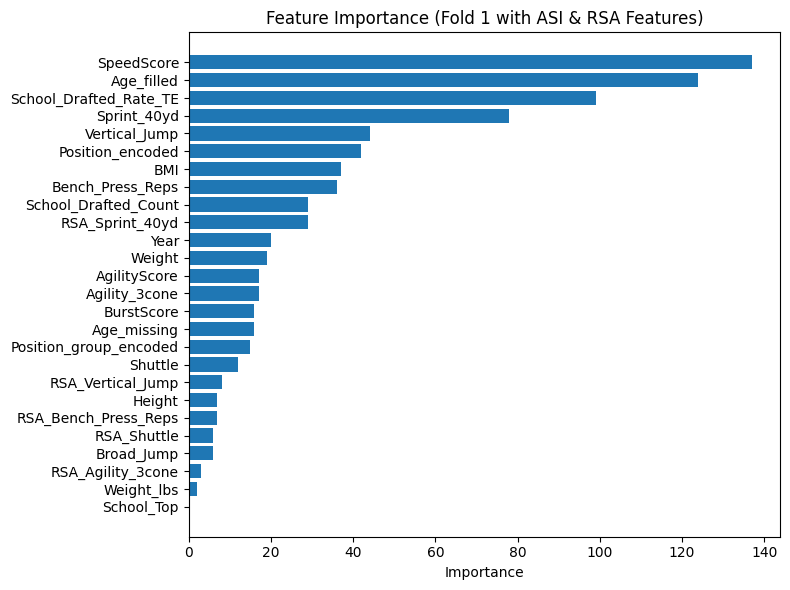

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[131]	valid_0's auc: 0.859954	valid_0's binary_logloss: 0.417628
✅ Fold 2 - Train AUC: 0.9026, Validation AUC: 0.8600
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[Ligh

In [121]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt  # 追加

# ✅ 固定パラメータ
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X.columns

        # ソート（重要度降順）
        sorted_idx = importances.argsort()
        sorted_importances = importances[sorted_idx]
        sorted_feature_names = feature_names[sorted_idx]

        plt.figure(figsize=(8, 6))
        plt.barh(sorted_feature_names, sorted_importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


In [115]:
# 🔄 提出用ファイルの作成処理（LightGBMモデルに基づく予測）

# original_test を再読み込みして Id を復元
original_test = pd.read_csv(PATH + "test.csv")

# 提出用特徴量列は X.columns で確定させる
feature_cols = X.columns.tolist()

# test に存在しない列があれば埋める（安全）
missing_cols = set(feature_cols) - set(test.columns)
for col in missing_cols:
    test[col] = 0  # または np.nan / 平均値など

# 列順を揃える
X_test = test[feature_cols]


# LightGBMモデルで予測（Drafted=1 の確率）
y_pred = model.predict_proba(X_test)[:, 1]

# 提出用DataFrameを作成
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": 1 - y_pred  # ← これだけ変更
})

# 保存ディレクトリをプロジェクトルートに作成
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

import os
import datetime
import re  # ← これを忘れずに！

try:
    import ipynbname
    notebook_path = ipynbname.path()
    notebook_name = notebook_path.stem  # ファイル名（拡張子なし）
except:
    notebook_name = "14_0703_notebook()"   # fallback

# 数字とアンダースコア部分だけ抽出（例：06_0627）
match = re.search(r"\d{2}_\d{4}", notebook_name)
tag = match.group() if match else notebook_name

filename = f"submission_{tag}.csv"


# 提出ファイル名を組み立てる
filename = f"submission_{tag}.csv"
save_path = os.path.join(save_dir, filename)

# 書き出し
submission.to_csv(save_path, index=False)
print(f"✅ 提出ファイルを保存しました: {save_path}")

✅ 提出ファイルを保存しました: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_14_0703.csv
